In [13]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image, ImageDraw
import math
import os
os.chdir('/mnt/c/Users/ankit/Desktop/Msc AIML/msc-project/GAP/gap/')
from tasks import inpainting
'''
Credits : https://github.com/JiahuiYu/generative_inpainting/blob/master/inpaint_ops.py#L126

'''

'\nCredits : https://github.com/JiahuiYu/generative_inpainting/blob/master/inpaint_ops.py#L126\n\n'

In [9]:
class FlagInit:
    img_shapes = (256, 256)
    max_delta_height = 32
    max_delta_width = 32

FLAGS = FlagInit()
FLAGS.img_shapes

(256, 256)

In [98]:
inpainter = inpainting()

In [10]:
def bbox2mask(FLAGS, bbox):
    """Generate mask tensor from bbox.

    Args:
        bbox: tuple, (top, left, height, width)

    Returns:
        tf.Tensor: output with shape [1, H, W, 1]

    """
    def npmask(bbox, height, width, delta_h, delta_w):
        mask = np.zeros((1, height, width, 1), np.float32)
        h = np.random.randint(delta_h//2+1)
        w = np.random.randint(delta_w//2+1)
        mask[:, bbox[0]+h:bbox[0]+bbox[2]-h,
             bbox[1]+w:bbox[1]+bbox[3]-w, :] = 1.
        return mask
    img_shape = FLAGS.img_shapes
    height = img_shape[0]
    width = img_shape[1]
    mask = npmask(bbox, height, width, FLAGS.max_delta_height, FLAGS.max_delta_width)
    mask.reshape(([1] + [height, width] + [1]))
    return mask



In [100]:
def brush_stroke_mask(FLAGS):
    """Generate mask tensor from bbox.

    Returns:
        tf.Tensor: output with shape [1, H, W, 1]

    """
    min_num_vertex = 4
    max_num_vertex = 12
    mean_angle = 2*math.pi / 5
    angle_range = 2*math.pi / 15
    min_width = 12
    max_width = 40
    def generate_mask(H, W):
        average_radius = math.sqrt(H*H+W*W) / 8
        mask = Image.new('L', (W, H), 0)

        for _ in range(np.random.randint(1, 4)):
            num_vertex = np.random.randint(min_num_vertex, max_num_vertex)
            angle_min = mean_angle - np.random.uniform(0, angle_range)
            angle_max = mean_angle + np.random.uniform(0, angle_range)
            angles = []
            vertex = []
            for i in range(num_vertex):
                if i % 2 == 0:
                    angles.append(2*math.pi - np.random.uniform(angle_min, angle_max))
                else:
                    angles.append(np.random.uniform(angle_min, angle_max))

            h, w = mask.size
            vertex.append((int(np.random.randint(0, w)), int(np.random.randint(0, h))))
            for i in range(num_vertex):
                r = np.clip(
                    np.random.normal(loc=average_radius, scale=average_radius//2),
                    0, 2*average_radius)
                new_x = np.clip(vertex[-1][0] + r * math.cos(angles[i]), 0, w)
                new_y = np.clip(vertex[-1][1] + r * math.sin(angles[i]), 0, h)
                vertex.append((int(new_x), int(new_y)))

            draw = ImageDraw.Draw(mask)
            width = int(np.random.uniform(min_width, max_width))
            draw.line(vertex, fill=1, width=width)
            for v in vertex:
                draw.ellipse((v[0] - width//2,
                              v[1] - width//2,
                              v[0] + width//2,
                              v[1] + width//2),
                             fill=1)

        if np.random.normal() > 0:
            mask.transpose(Image.FLIP_LEFT_RIGHT)
        if np.random.normal() > 0:
            mask.transpose(Image.FLIP_TOP_BOTTOM)
        mask = np.asarray(mask, np.float32)
        mask = np.reshape(mask, (1, H, W, 1))
        return mask
    img_shape = FLAGS.img_shapes
    height = img_shape[0]
    width = img_shape[1]
    mask = generate_mask(height, width)
    mask = mask.reshape(([1] + [height, width]))
    return torch.from_numpy(mask)


In [101]:
brush_stroke_mask(FLAGS).shape

torch.Size([1, 256, 256])

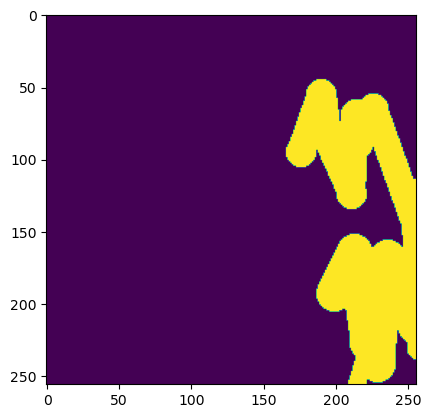

In [96]:
plt.imshow(brush_stroke_mask(FLAGS)[0])

In [99]:
inpainter.generate_mask().shape

torch.Size([1, 256, 256])

In [102]:
[5] * 2

[5, 5]